In [2]:
from turtle import shape
import nibabel as nib
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import pandas as pd
import imblearn
import re
import seaborn as sns

# Setting paths for different folders
FLAIR_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\FLAIRinT1space_withLacunes_35.tar'
T1_Lacunes_Incorrect = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space.tar'
T1_Lacunes_Correct = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space_JiyangCorrected20210920'
T1_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1_withLacunes_35.tar'
T1_Soft_Tissue = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1softTiss_withLacunes_35.tar'
T1_Soft_Tissue_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35.tar'
T1_Soft_Tissue_Binary_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35_binary.tar'


In [3]:
def read_data():
    #Read all data into list
    T1_scan_data = []
    for file in os.listdir(T1_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            T1_scan_data.append(Data_list)

    #Read all FLAIR data into list
    FLAIR_scan_data = []
    for file in os.listdir(FLAIR_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(FLAIR_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            FLAIR_scan_data.append(Data_list)

    #Lacune Exists
    Lacune_indicator_data = []
    for file in os.listdir(T1_Lacunes_Correct):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Lacunes_Correct, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Lacune_indicator_data.append(Data_list)

    Soft_tiss_data = []
    for file in os.listdir(T1_Soft_Tissue):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Soft_tiss_data.append(Data_list)

    return T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data
T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data = read_data()
print("complete")

complete


In [4]:
def sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_lacune = []
    X_test_3D_lacune = []
    Y_train_3D_lacune = []
    Y_test_3D_lacune = []
    Y_train_segment_3D_lacune = []
    Y_test_segment_3D_lacune = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]

            #Sample lacunes
            for x in range(0, data.shape[0]):
                for y in range(0, data.shape[1]):
                    for z in range(0, data.shape[2]):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss)

                            lacune_binary = Lacune_data[x-15:x+15, y-15:y+15, z-15:z+15] 

                            if brain_image <= 24:
                                if (Lacune_data[x,y,z] == 1):
                                    X_train_3D_lacune.append(brain_values)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_segment_3D_lacune.append(lacune_binary)

                            else:
                                if (Lacune_data[x,y,z] == 1):
                                    X_test_3D_lacune.append(brain_values)
                                    Y_test_3D_lacune.append(1)
                                    Y_test_segment_3D_lacune.append(lacune_binary)
                            
            brain_image += 1
            print(brain_image)
    return X_train_3D_lacune, X_test_3D_lacune, Y_train_3D_lacune, Y_test_3D_lacune, Y_train_segment_3D_lacune, Y_test_segment_3D_lacune
X_train_3D_lacune, X_test_3D_lacune, Y_train_3D_lacune, Y_test_3D_lacune, Y_train_segment_3D_lacune, Y_test_segment_3D_lacune = sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [5]:
def non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_nlacune = []
    X_test_3D_nlacune = []
    Y_train_3D_nlacune = []
    Y_test_3D_nlacune = []
    Y_train_segment_3D_nlacune = []
    Y_test_segment_3D_nlacune = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            
            #Sample lacunes
            #Reduce step size to 5??
            for x in range(0, data.shape[0], 15):
                for y in range(0, data.shape[1], 15):
                    for z in range(0, data.shape[2], 15):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss)

                            lacune_binary = Lacune_data[x-15:x+15, y-15:y+15, z-15:z+15]

                            if brain_image <= 24:
                                # No lacune exists in the 3D patch, add to train set
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_train_3D_nlacune.append(brain_values)
                                    Y_train_3D_nlacune.append(0)
                                    Y_train_segment_3D_nlacune.append(lacune_binary)
                                    
                            else:
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_test_3D_nlacune.append(brain_values)
                                    Y_test_3D_nlacune.append(0)
                                    Y_test_segment_3D_nlacune.append(lacune_binary)
            brain_image += 1
            print(brain_image)

    return X_train_3D_nlacune, X_test_3D_nlacune, Y_train_3D_nlacune, Y_test_3D_nlacune, Y_train_segment_3D_nlacune, Y_test_segment_3D_nlacune
X_train_3D_nlacune, X_test_3D_nlacune, Y_train_3D_nlacune, Y_test_3D_nlacune, Y_train_segment_3D_nlacune, Y_test_segment_3D_nlacune = non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [6]:
X_train = np.concatenate((X_train_3D_lacune, X_train_3D_nlacune), axis=0)
X_test = np.concatenate((X_test_3D_lacune, X_test_3D_nlacune), axis=0)
Y_train = np.concatenate((Y_train_3D_lacune, Y_train_3D_nlacune), axis=0)
Y_test = np.concatenate((Y_test_3D_lacune, Y_test_3D_nlacune), axis=0)
Y_train_segment = np.concatenate((Y_train_segment_3D_lacune, Y_train_segment_3D_nlacune), axis=0)
Y_test_segment = np.concatenate((Y_test_segment_3D_lacune, Y_test_segment_3D_nlacune), axis=0)
print(len(X_train_3D_nlacune))
print(len(X_train_3D_lacune))
print("done")

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


27106
2351
done


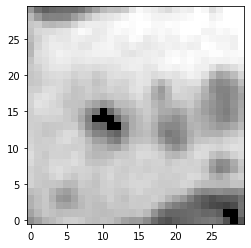

In [103]:
input_image = X_train[200][7][:, 15, :]*255
input_image = input_image.astype('uint8')
plt.imshow(input_image, cmap="gray", origin="lower")
plt.show()

In [104]:
input_image
stacked_img = np.stack((input_image,)*3, axis=-1)

In [105]:
input_image = cv2.cvtColor(stacked_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(input_image, 70, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [106]:
closed_contours = []

i = 0
for cnt in contours:
   if cv2.isContourConvex(cnt) == True:
      closed_contours.append(cnt)
   else:
      i+=1

In [107]:
len(closed_contours)

0

In [108]:
i

2

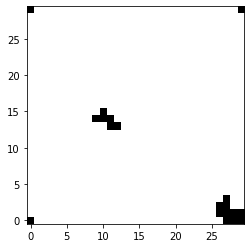

In [109]:
new_image = cv2.drawContours(thresh, contours[0], -1, (0,255,0), 1)
plt.imshow(new_image, cmap="gray", origin="lower")
plt.show()

In [82]:
perimeter = cv2.arcLength(contours[1],True)
perimeter

13.071067690849304

In [80]:
area = cv2.contourArea(contours[1], True)
area

12.5

In [87]:
import math
contours_cirles = []
# check if contour is of circular shape
for con in contours:
    perimeter = cv2.arcLength(con, True)
    area = cv2.contourArea(con)
    if perimeter == 0:
        break
    circularity = 4*math.pi*(area/(perimeter*perimeter))
    print(circularity)
    if 0.7 < circularity < 1.2:
        contours_cirles.append(con)

0.5066082753321259
0.9193857107025737


In [59]:
ret

100.0

In [ ]:


# check if contour is of circular shape
for con in contours_area:
    perimeter = cv2.arcLength(con, True)
    area = cv2.contourArea(con)
    if perimeter == 0:
        break
    circularity = 4*math.pi*(area/(perimeter*perimeter))
    print circularity
    if 0.7 < circularity < 1.2:
        contours_cirles.append(con)